# ECON 570: Final Project

# Evaluation of Job Training Program with Nonexperimental Data

Masashi Yoshioka (3200-3439-52), Jincen Jiang (XXXX-XXXX-XX), Shuxian Mao (6221-2815-32)

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import basic functions
import numpy as np
import pandas as pd
import pyreadr
import random

# Import helper functions
from utils.functions import *

# Set random seeds
np.random.seed(570)
random.seed(570)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

## 1. Introduction

### 1.1 Research Question

In this project, we will try to evaluate the job training program called the National Supported Work (NSW) Demonstration implemented around the U.S. in 1970s. In particular, we will examine whether we can replicate average treatment effect (ATE) and/or average treatment effect on treated (ATET) estimates obtained from experimental data by relying solely on  nonexperimental data.  

In short, our research question can be specified as: ***Could we obtain a reliable ATE and/or ATET estimate of the NSW by nonexperimental data?***

### 1.2 Literature Review

There has been a huge discussion about whether we can estimate a treatment effect using nonexperimental data. The answer still remains to be seen.  

This topic was first introduced by LaLonde (1986). He used data from randomized experiments that were conducted as a part of the NSW (the details will be explained in 2.1) and investigated the extent to which nonexperimental ATE estimates of the NSW can replicate experimental estimates. He first obtained the experimental ATE estimates from randomized experiments by, for example, taking a difference between averages of treatment and control groups, which would be an unbiased estimate for the ATE as long as the experiments were truly randomized. Then, he compared the results with the estimates from nonexperimental data (CPS and PSID namely) that were obtained using several econometric methods. He basically failed to obtain the nonexperimental ATE estimates that are close to experimental ones and concluded that the standard nonexperimental estimation methods are inaccurate relative to experimental benchmarks or sensitive to the modeling specifications.  

On the other hand, Dehejia and Wahba (1999, 2002) used the same dataset as LaLonde (1986) and concluded that they could successfully obtain the nonexprimental ATET estimates that were close to the benchmark experimental estimate by propensity score methods. They first provided a theoretical discussion about unconfoundedness and propensity score, and then applied the propensity score matching to the data of LaLonde (1986). They claimed that although the propensity score method cannot in principle account for important unobservables if any, it is still worth exploring first the information contained in the observable covariates.  

However, Smith and Todd (2005) pointed out that Dehejia and Wahba (1999, 2002) had excluded some samples from the data of LaLonde (1986), which should have made it easier to estimate the ATET by nonexperimental data. They applied  to original LaLonde (1986) dataset the same propensity score matching method that Dehejia and Wahba (1999, 2002) had used, and discovered that the estimates were very sensitive to the choice of variables used in the propensity score estimation and the choice of samples of analysis. They concluded that the propensity score matching would not represent a general solution to causal inferences whereas it is a potentially useful tool.  

### 1.3 Why Our Research Question Matters?

We will try to contribute to the above discussion by applying causal inference methods that we have learned in class. Our research question is very important from the empirical perspective because experimental data are rarely available in economics. We often need to use nonexperimental data to evaluate the effect of a certain program. Finding a causal relationship from nonexperimental data is obviously one of the most important tasks of econometrics, but it might not provide a correct estimation in general if the suggestions by LaLonde (1986) and Smith and Todd (2005) are true.

### 1.4 Research Description

To answer our research question, we will use the dataset of LaLonde (1986) and try to estimate the ATE and/or ATET of the NSW by applying a variety of methods. We will first apply regression (or imputation estimator) methods. Then, we will rely on different estimation methods that use propensity score, namely propensity score matching, Inverse Probability of Treatment Weighting (IPTW) and doubly robust estimators. In addition to the logistic regression that Dehejia and Wahba (1999, 2002) used to estimate propensity score, we will use Random Forest and Gradient Boosting to examine whether machine learning approaches can improve the estimation. We will use both the original data of LaLonde (1986) and its subset selected by Dehejia and Wahba (1999, 2002) to see if the criticism by Smith and Todd (2005) holds true.  

The rest of the notebook is organized as follows. Section 2 describes the data that we will use. Section 3 applies various models (regression, propensity score matching, IPTW estimator and doubly robust estimator) to obtain the ATE/ATET estimates. Section 4 analyzes what we have found and compares the results from nonexperimental data with experimental estimates. Section 5 concludes and suggests future work.

## 2. Data

### 2.1 The National Supported Work (NSW) Demonstration

We use a dataset from the NSW Demonstration, which has been commonly used in the causal inference literature, including LaLonde (1986), Dehejia and Wahba (1999, 2002) and Smith and Todd (2005) as explained above. 

The NSW was a job training program conducted in the mid-1970s at 15 sites around the United States. Our dataset is focused on the program implemented in 10 sites from April 1975 to August 1977 among others. The program was targeted at 4 types of hard-to-employ people: female long-term AFDC<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) recipients, ex-drug addicts, ex-climinal offenders and high school dropouts. The potential participants had to satisfy a set of eligibility criteria that included: (i) they must have been currently unemployed, (ii) they must have spent no more than 3 months on one regular job of at least 20 hours per week during the preceding 6 months, and so forth. These criteria as well as self-selection made the participants in NSW differ from the U.S. population in many characteristics.

The program operated as a randomized experiment by randomly assigning some applicants to a control group that was not allowed to participate in the program. For those assigned to the treatment group, the program guaranteed a job for 9 to 18 months, depending on the target group and site. The program paid the treatment group for their work, but the offered wage was lower than they would have received on a regular job. The participants were forced to find a regular job after their terms in the program expired.

The treatment and control groups were interviewed five times in total, one of which was a baseline and the others were follow-ups. Many people failed to complete these interviews and thus the sample attrition could have possibly caused biases. However, LaLonde (1986) suggests that the largest source of attrition, which is the interview schedule according to LaLonde (1986), should not affect the integrity of the experimental design because the interviews were randomly scheduled. Here we just assume that LaLonde (1986) is right and will not deal with the potential sample attrition problem. The interviews provide information on demographic characteristics, employment history, household income and so forth.

We are interested in the effect of the NSW on earnings of participants. Since the program randomly assigned applicants to treatment and control groups, the experimental data would presumably give us an unbiased estimate for the average treatment effect (ATE) of the program. LaLonde (1986) compared the experimental data with nonexperimental data such as Current Population Survey (CPS) and Panel Study of Income Dynamics (PSID), concluding that nonexperimental data fail to generate similar results to experimental data. Dehejia and Wahba (1999, 2002) concentrate on subsamples whose earnings in 1974 are available, and conclude that propensity-score matching would generate the results close to experimental design. Thus, our dataset consists of 6 different groups of samples: treatment group in LaLonde (1986), control group in LaLonde (1986), treatment subgroup in Dehejia and Wahba (1999, 2002), control subgroup in Dehejia and Wahba (1999, 2002), nonexperimental data from CPS and those from PSID. Using the dataset, we will see if nonexperimental data can generate estimates that are close enough to those given by experimental data.

### 2.2 Sample Restrictions

The datasets were retrieved from https://github.com/jjchern/lalonde/tree/master/data on February 2, 2022. Note that it only includes the male samples due to the data availability of LaLonde (1986). That is why Dehejia and Wahba (1999, 2002) and Smith and Todd (2005) also focus on males. This repository also includes the subsamples of CPS and PSID that were chosen by LaLonde (1986) to make them resemble the NSW applicants to the extent possible. However, according to Dehejia and Wahba (1999, 2002), choosing subsamples arbitrarily from the nonexperimental data would not improve the estimate. Thus, we will use the 6 groups described in 2.1 and discard subsamples of CPS and PSID. For the same reason, we will not do any sample restrictions including removing outliers from the data. Since the experiment was randomized, using all the samples would give an unbiased estimate of ATE. On the other hand, arbitrary sample restrictions can make treatment and control groups incomparable, which could cause a bias in the estimate.

### 2.3 Summary Statistics

First of all, we describe the summary statistics of each group below. The data includes the treatment status (`treat`), age (`age`), years of education (`education`), dummy for black (`black`), dummy for hispanic (`hispanic`), dummy for being married (`married`), dummy for dropout (`nodegree`), earnings in 1975 (`re75`) and in 1978 (`re78`). Note that the earnings in 1974 (`re74`) were not available for LaLonde (1986) experimental samples.

#### 2.3.1 LaLonde (1986) Experimental Data

In [3]:
# LaLonde's original dataset
df_nsw = pyreadr.read_r('./data/nsw.rda')['nsw']
df_nsw.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,Lalonde Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898
1,Lalonde Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043
2,Lalonde Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219
3,Lalonde Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996
4,Lalonde Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886


In [4]:
# Treatment group in LaLonde (1986)
print('LaLonde Treatment Group')
df_nsw[df_nsw['treat'] == 1].describe().T

LaLonde Treatment Group


,count,mean,std,min,25%,50%,75%,max
treat,297.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
age,297.0,24.626263,6.686391,17.0,20.000000,23.000000,27.000000,49.000000
education,297.0,10.380471,1.817712,4.0,9.000000,11.000000,12.000000,16.000000
black,297.0,0.801347,0.399660,0.0,1.000000,1.000000,1.000000,1.000000
hispanic,297.0,0.094276,0.292706,0.0,0.000000,0.000000,0.000000,1.000000
married,297.0,0.168350,0.374808,0.0,0.000000,0.000000,0.000000,1.000000
nodegree,297.0,0.730640,0.444376,0.0,0.000000,1.000000,1.000000,1.000000
re75,297.0,3066.098191,4874.888996,0.0,0.000000,1117.438965,4310.455078,37431.660156
re78,297.0,5976.352024,6923.796406,0.0,549.298401,4232.309082,9381.294922,60307.929688


In [5]:
# Control group in LaLonde (1986)
print('LaLonde Control Group')
df_nsw[df_nsw['treat'] == 0].describe().T

LaLonde Control Group


,count,mean,std,min,25%,50%,75%,max
treat,425.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
age,425.0,24.447059,6.590276,17.0,19.0,23.000000,28.000000,55.000000
education,425.0,10.188235,1.618686,3.0,9.0,10.000000,11.000000,14.000000
black,425.0,0.800000,0.400471,0.0,1.0,1.000000,1.000000,1.000000
hispanic,425.0,0.112941,0.316894,0.0,0.0,0.000000,0.000000,1.000000
married,425.0,0.157647,0.364839,0.0,0.0,0.000000,0.000000,1.000000
nodegree,425.0,0.814118,0.389470,0.0,1.0,1.000000,1.000000,1.000000
re75,425.0,3026.682756,5201.249820,0.0,0.0,823.254395,3649.769043,36941.269531
re78,425.0,5090.048301,5718.088763,0.0,0.0,3746.700928,8329.823242,39483.531250


We can see that the characteristics of treatment and control groups are quite similar to each other except `re78`, which is an outcome of the program. Each variable has a similar mean, standard deviation and so forth. Since the experiment was randomized, treatment and control groups should be comparable in pre-treatment variables. The above statistics are consistent with the randomized design.

#### 2.3.2 Dehejia and Wahba (1999, 2002) Experimental Data

In [6]:
# Dehejia and Wahba (1999, 2002) subsamples
df_nsw_dw = pyreadr.read_r('./data/nsw_dw.rda')['nsw_dw']
df_nsw_dw.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [7]:
# Treatment group in Dehejia and Wahba (1999, 2002)
print('Dehejia and Wahba Treatment Group')
df_nsw_dw[df_nsw_dw['treat'] == 1].describe().T

Dehejia and Wahba Treatment Group


,count,mean,std,min,25%,50%,75%,max
treat,185.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
age,185.0,25.816216,7.155019,17.0,20.000000,25.000000,29.000000,48.000000
education,185.0,10.345946,2.010650,4.0,9.000000,11.000000,12.000000,16.000000
black,185.0,0.843243,0.364558,0.0,1.000000,1.000000,1.000000,1.000000
hispanic,185.0,0.059459,0.237124,0.0,0.000000,0.000000,0.000000,1.000000
married,185.0,0.189189,0.392722,0.0,0.000000,0.000000,0.000000,1.000000
nodegree,185.0,0.708108,0.455867,0.0,0.000000,1.000000,1.000000,1.000000
re74,185.0,2095.573693,4886.620354,0.0,0.000000,0.000000,1291.468018,35040.070312
re75,185.0,1532.055313,3219.250879,0.0,0.000000,0.000000,1817.284058,25142.240234
re78,185.0,6349.143502,7867.402183,0.0,485.229797,4232.309082,9642.999023,60307.929688


In [8]:
# Control group in Dehejia and Wahba (1999, 2002)
print('Dehejia and Wahba Control Group')
df_nsw_dw[df_nsw_dw['treat'] == 0].describe().T

Dehejia and Wahba Control Group


,count,mean,std,min,25%,50%,75%,max
treat,260.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
age,260.0,25.053846,7.057745,17.0,19.0,24.000000,28.000000,55.000000
education,260.0,10.088462,1.614325,3.0,9.0,10.000000,11.000000,14.000000
black,260.0,0.826923,0.379043,0.0,1.0,1.000000,1.000000,1.000000
hispanic,260.0,0.107692,0.310589,0.0,0.0,0.000000,0.000000,1.000000
married,260.0,0.153846,0.361497,0.0,0.0,0.000000,0.000000,1.000000
nodegree,260.0,0.834615,0.372244,0.0,1.0,1.000000,1.000000,1.000000
re74,260.0,2107.026651,5687.905639,0.0,0.0,0.000000,139.424698,39570.679688
re75,260.0,1266.909015,3102.982088,0.0,0.0,0.000000,650.096451,23031.980469
re78,260.0,4554.801120,5483.836001,0.0,0.0,3138.795532,7288.420044,39483.531250


Compared to LaLonde (1986), some of the variables appear to show different distributions in Dehejia and Wahba (1999, 2002) datasets. For instance, earnings in 1975 (`re75`) of treatment group are higher than those of control group, although the difference does not appear to be statistically significant. By choosing only the samples whose earnings in 1974 are available, Dehejia and Wahba (1999, 2002) might have distorted the samples and hurt the comparability between treatment and control groups.

#### 2.3.3 Nonexperimental Data (CPS and PSID)

In [9]:
# CPS data
df_cps = pyreadr.read_r('./data/cps_controls.rda')['cps_controls']
df_cps.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


In [10]:
print('CPS Control Group')
df_cps.describe().T

CPS Control Group


,count,mean,std,min,25%,50%,75%,max
treat,15992.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
age,15992.0,33.225238,11.045216,16.0,24.000000,31.000000,42.000000,55.000000
education,15992.0,12.027514,2.870846,0.0,11.000000,12.000000,13.000000,18.000000
black,15992.0,0.073537,0.261024,0.0,0.000000,0.000000,0.000000,1.000000
hispanic,15992.0,0.072036,0.258556,0.0,0.000000,0.000000,0.000000,1.000000
married,15992.0,0.711731,0.452971,0.0,0.000000,1.000000,1.000000,1.000000
nodegree,15992.0,0.295835,0.456432,0.0,0.000000,0.000000,1.000000,1.000000
re74,15992.0,14016.800360,9569.795964,0.0,4403.452393,15123.580078,23584.179688,25862.320312
re75,15992.0,13650.803522,9270.403408,0.0,4398.823242,14557.110352,22923.736816,25243.550781
re78,15992.0,14846.659650,9647.391501,0.0,5669.298096,16421.974609,25564.669922,25564.669922


In [11]:
# PSID data
df_psid = pyreadr.read_r('./data/psid_controls.rda')['psid_controls']
df_psid.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,PSID,0.0,47.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PSID,0.0,50.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,PSID,0.0,44.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PSID,0.0,28.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,PSID,0.0,54.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
print('PSID Control Group')
df_psid.describe().T

PSID Control Group


,count,mean,std,min,25%,50%,75%,max
treat,2490.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
age,2490.0,34.850602,10.440757,18.0,26.000000,33.000000,44.000000,55.000000
education,2490.0,12.116867,3.082435,0.0,11.000000,12.000000,14.000000,17.000000
black,2490.0,0.250602,0.433447,0.0,0.000000,0.000000,1.000000,1.000000
hispanic,2490.0,0.032530,0.177439,0.0,0.000000,0.000000,0.000000,1.000000
married,2490.0,0.866265,0.340436,0.0,1.000000,1.000000,1.000000,1.000000
nodegree,2490.0,0.305221,0.460593,0.0,0.000000,0.000000,1.000000,1.000000
re74,2490.0,19428.745805,13406.877171,0.0,10775.966797,18417.107422,26450.101562,137148.687500
re75,2490.0,19063.337668,13596.954865,0.0,9846.774414,17903.226562,26496.773438,156653.234375
re78,2490.0,21553.920924,15555.345539,0.0,11526.266602,20688.171875,29554.531250,121173.578125


The above statistics obviously show that neither CPS nor PSID samples are comparable with LaLonde treatment group or Dehejia and Wahba treatment group. For instance, samples in CPS are 33 years old and those in PSID are 35 years on average, whereas the average age of LaLonde and Dehejia and Wahba treatment groups are 25-26. We will show the differences more graphically below. Before that, we append all the datasets for convenience.

In [13]:
# Combine all of the datasets
df_nsw.loc[df_nsw['treat'] == 1, 'data_id'] = 'LT'
df_nsw.loc[df_nsw['treat'] == 0, 'data_id'] = 'LC'
df_nsw_dw.loc[df_nsw_dw['treat'] == 1, 'data_id'] = 'DWT'
df_nsw_dw.loc[df_nsw_dw['treat'] == 0, 'data_id'] = 'DWC'
df_cps.data_id = 'CPS'

df = pd.concat([df_nsw, df_nsw_dw, df_cps, df_psid]).reset_index(drop = True)
df.data_id = pd.Categorical(df.data_id, ['LT', 'LC', 'DWT', 'DWC', 'CPS', 'PSID'])
df.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,re74
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,NaN
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,NaN
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,NaN
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996,NaN
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,NaN


We also define a varaible `dif` which represents the difference between `re78` and `re75`.

In [14]:
# Add a difference in revenues
df['dif'] = df['re78'] - df['re75']
df

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,re74,dif
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,9930.045898,NaN,9930.045898
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,3595.894043,NaN,3595.894043
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,24909.449219,NaN,24909.449219
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,7506.145996,NaN,7506.145996
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,289.789886,NaN,289.789886
...,...,...,...,...,...,...,...,...,...,...,...,...
19644,PSID,0.0,47.0,8.0,0.0,0.0,1.0,1.0,33837.097656,38568.664062,44667.363281,4731.566406
19645,PSID,0.0,32.0,8.0,0.0,0.0,1.0,1.0,67137.093750,59109.062500,47022.402344,-8028.031250
19646,PSID,0.0,47.0,10.0,0.0,0.0,1.0,1.0,47968.113281,55710.292969,48197.964844,7742.179688
19647,PSID,0.0,54.0,0.0,0.0,1.0,1.0,1.0,44220.968750,20540.398438,49228.539062,-23680.570312


#### 2.3.4 Comparisons

To make clearer the differences in sample groups, we will further show various statistics below.

##### Conditional Mean

In [15]:
# Conditional mean
df.groupby('data_id').mean().T

data_id,LT,LC,DWT,DWC,CPS,PSID
treat,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
age,24.626263,24.447059,25.816216,25.053846,33.225238,34.850602
education,10.380471,10.188235,10.345946,10.088462,12.027514,12.116867
black,0.801347,0.800000,0.843243,0.826923,0.073537,0.250602
hispanic,0.094276,0.112941,0.059459,0.107692,0.072036,0.032530
married,0.168350,0.157647,0.189189,0.153846,0.711731,0.866265
nodegree,0.730640,0.814118,0.708108,0.834615,0.295835,0.305221
re75,3066.098191,3026.682756,1532.055313,1266.909015,13650.803522,19063.337668
re78,5976.352024,5090.048301,6349.143502,4554.801120,14846.659650,21553.920924
re74,NaN,NaN,2095.573693,2107.026651,14016.800360,19428.745805


The above table shows the conditional mean of each characteristic. We can see that the NSW experimental data are totally different from CPS and PSID. As we have already seen above, the average age is much lower in the NSW data than in CPS/PSID. In addition, compared to CPS/PSID, the NSW samples have the lower average year of education, much more black people, more hispanic people, more singles and more dropouts. These differences are not surprising considering the eligibility criteria for the NSW. Moreover, the average earnings of the NSW samples are much lower than those of CPS/PSID. Therefore, it is obvious that taking differences between experimental treatment group and *nonexperimental* control group would not provide a good estimate of the effect of the program.

##### Boxplot

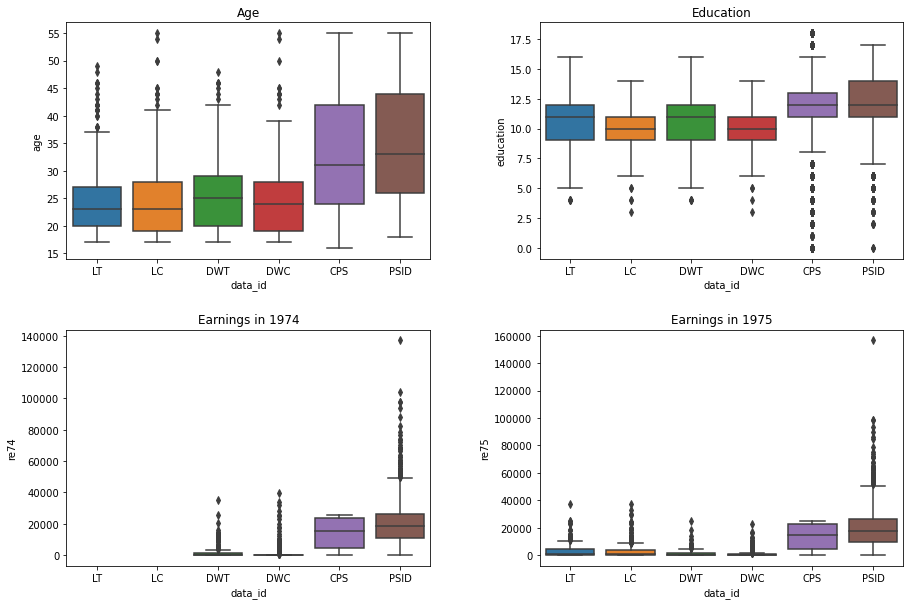

In [16]:
# Boxplots
fn_boxplots(df = df)

The above boxplots show the distributions of pre-treatment continuous variables within each group. Again, it is obvious that the NSW samples are totally different from CPS/PSID in all the characteristics. In order to estimate the ATE from the nonexperimental data, we should take these differences into consideration.

## 3. Modeling

In this section, we will apply the following 4 methods: regression, propensity score matching, IPTW estimator and doubly robust estimator.  
  
As a notation, we will let $D$ denote the treatment variable (`treat`), $X$ denote the covariates and $Y$ denote the outcome below. Since `re74` is not available for LaLonde (1986) dataset, we define $X$ by the other pre-treatment variables, i.e., `age`, `education`, `black`, `hispanic`, `married`, `nodegree` and `re75`. We assume two kinds of outcomes, difference in earnings between 1975 and 1978 (`dif`) and earnings in 1978 (`re78`), as $Y$. If the experiment is randomized, the choice of $Y$ would not affect the estimates because the pre-treatment variable `re75` should be comparable between treatment and control groups under randomized selection. On the other hand, it can affect the estimates when using nonexperimental data. We will assume both outcomes to make our research comprehensive.

### 3.1 Regression

Under the assumption of unconfoundedness $Y_0, Y_1 \perp D | X$ where $Y_0$ and $Y_1$ are potential outcomes when treated and controlled, respectively, we can obtain the ATE and ATET by

$$
\begin{align*}
ATE &\equiv E[Y_1 - Y_0] \\
    &= E_X[E[Y_1 - Y_0 | X]] \\
    &= E_X[E[Y_1|X] - E[Y_0 | X]] \\
    &= E_X[E[Y_1|X, D=1] - E[Y_0 | X, D=0]] \\
    &= E_X[E[Y|X, D=1] - E[Y|X, D=0]], \\
ATET &\equiv E[Y_1 - Y_0 | D = 1] \\
     &= E_{X|D = 1}[E[Y_1 - Y_0 | X, D = 1]] \\
     &= E_{X|D = 1}[E[Y_1|X, D = 1] - E[Y_0 | X, D = 1]] \\
     &= E_{X|D = 1}[E[Y_1|X, D = 1] - E[Y_0 | X, D = 0]] \\
     &= E_{X|D = 1}[E[Y|X, D=1] - E[Y|X, D=0]].
\end{align*}
$$

In this section, we try to estimate $\mu_1 (X) \equiv E[Y | D = 1, X]$ and $\mu_0 (X) \equiv E[Y | D = 0, X]$ using different regression models: i) Linear regression, ii) Random Forest regression and iii) Gradient Boosting regression. Using the estimates $\hat{\mu}_1 (X)$ and $\hat{\mu}_0 (X)$, we can estimate the ATE and ATET by
$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \sum_{i = 1}^n \left( \hat{\mu}_1 (X_i) - \hat{\mu}_0 (X_i) \right),\\
\hat{\tau}_{ATET} &= \frac{1}{n_1} \sum_{i|D_i = 1} \left( \hat{\mu}_1 (X_i) - \hat{\mu}_0 (X_i) \right),
\end{align*}
$$
respectively, where $n$ is a sample size and $n_1 \equiv \sum_{i = 1}^n D_i$ is the number of treated samples.  
  
The above estimators are called regression imputation estimators (e.g., Abadie & Cattaneo, 2018) because they essentially impute the unobserved potential outcomes by regression.

#### 3.1.1 Linear Regression

We first apply linear regression models to obtain the estimates. That is, we assume $E[Y|D, X] = \alpha + \tau D + X \beta$, which implies $E[Y|D = 1, X] - E[Y|D = 0, X] = \tau$. Thus, in this specification of fixed coefficient model, both ATE and ATET will be identical to $\tau$.  
  
We run OLS to obtain the estimate for $\tau$. When experimental data are used, the OLS estimator for $\tau$ would be unbiased regardless of the choice of the covariates whereas including covariates can reduce the standard error of the estimate. Since all the covariates are pre-treatment variables, we do not have to worry about selection biases. 
  
For comparison, we specify three sets of covariates: i) no covariates, ii) age and squared age, and iii) age, squared age and all the other covariates.  

First, we assume the difference in earnings between 1975 and 1978 (`dif`) as outcome $Y$. 

In [17]:
# Obtain benchmark experimental ATE/ATET estimates over LaLonde dataset
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'LC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: LaLonde


,Without control,With age,With all control
treat,846.8883,856.9110,802.0486*
,(560.1417),(557.6783),(467.7103)
age,,-703.6823***,-135.0223
,,(241.6312),(211.9982)
age2,,11.5827***,2.6144
,,(4.0793),(3.5650)
black,,,-1437.7471*
,,,(800.9013)
education,,,196.3502
,,,(181.3215)


The coefficient on `treat` is the estimate for ATE/ATET. We can see that it is stable and around 800&ndash;900 when we use LaLonde's original experimental data. Assuming that the experiments were truly randomized, which appears to be a reasonable assumption considering the comparable conditional distributions in Section 2, we can use the result as a benchmark for ATE/ATET estimate of LaLonde dataset.  

Now we run OLS over subsamples by Dehejia and Wahba (1999, 2002). We call the subsamples 'DW subset' henceforth.

In [18]:
# Obtain benchmark experimental ATE/ATET estimates over the DW subset
fn_regression_result(outcome = 'dif', treat_id = 'DWT', control_id = 'DWC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: Dehejia and Wahba
Control: Dehejia and Wahba


,Without control,With age,With all control
treat,1529.1961**,1516.9969**,1631.4108**
,(679.5380),(682.2371),(637.3277)
age,,-46.6970,133.4218
,,(279.9331),(269.0130)
age2,,1.1926,-1.3840
,,(4.6231),(4.4308)
black,,,-2136.4072*
,,,(1167.1488)
education,,,366.1767
,,,(229.0491)


Notably, the ATE/ATET estimate on DW subset is much larger than on LaLonde's original dataset. It is about 1,500&ndash;1,600, which would be the benchmark for DW subset.

Now, we try to obtain these results using nonexperimental data. First, we compare LaLonde treatment dataset (`LT` in our notation) and CPS/PSID. If the unconfoundedness holds and our specification $E[Y|D, X] = \alpha + \tau D + X \beta$ is correct, we should be able to get similar results even when using CPS/PSID.

In [19]:
# Obtain nonexperimental ATE/ATET estimates over LaLonde treatment and CPS
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'CPS', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: CPS


,Without control,With age,With all control
treat,1714.3977***,195.1746,-1102.3224**
,(452.2939),(441.8344),(450.4264)
age,,-561.3006***,-18.9340
,,(36.6097),(38.2757)
age2,,5.7530***,-0.7210
,,(0.5158),(0.5326)
black,,,-884.0209***
,,,(214.8328)
education,,,135.3354***
,,,(29.0619)


In [20]:
# Obtain nonexperimental ATE/ATET estimates over LaLonde treatment and PSID
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'PSID', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: PSID


,Without control,With age,With all control
treat,419.6706,-749.2072,-2118.5967***
,(650.5836),(691.9516),(745.7990)
age,,25.8463,244.8416
,,(154.1027),(151.5026)
age2,,-2.1310,-4.0098*
,,(2.1075),(2.0718)
black,,,-706.9273
,,,(489.1923)
education,,,638.2547***
,,,(103.0949)


Compared to the experimental estimates, the nonexperimental estimates for ATE/ATET vary significantly depending on the modeling specification and selection of controlled samples. It ranges from -2119 to 1714. Even worse, some of the results are highly statistically significant, which is misleading for researchers&mdash;they can easily overstate or understate the causal effect of the NSW. Unfortunately, none of them could generate a similar estimate to the benchmark.  

We apply the same methods to DW subset as well. The following table summarizes all the results.

In [21]:
# Summarize the linear regression results
reg_summary_dif = fn_regression_summary(df = df, outcome = 'dif')
reg_summary_dif

,Outcome,Treatment,Control,Without control,With age,With all control
0,dif,LT,LC,846.888287,856.910955,802.048565
1,dif,LT,CPS,1714.397705,195.174602,-1102.322439
2,dif,LT,PSID,419.670577,-749.207210,-2118.596666
3,dif,DWT,DWC,1529.196083,1516.996931,1631.410849
4,dif,DWT,CPS,3621.232061,2383.311533,524.908817
5,dif,DWT,PSID,2326.504934,1256.927930,-265.312462


The implications are basically the same with DW subset. That is, the nonexperimental ATE/ATET estimates differ to a significant extent depending on modeling specifications and controlled samples. None of the nonexperimental estimates are close to the benchmark.  

In the following, the earnings in 1978 (`re78`) are used as an outcome instead of `dif`. The table presents the results.

In [22]:
# Summarize the linear regression results for earnings in 1978
reg_summary_re78 = fn_regression_summary(df = df, outcome = 're78')
reg_summary_re78

,Outcome,Treatment,Control,Without control,With age,With all control
0,re78,LT,LC,886.303722,881.739626,802.048565
1,re78,LT,CPS,-8870.307627,-7172.308044,-1102.322439
2,re78,LT,PSID,-15577.568900,-13267.657059,-2118.596666
3,re78,DWT,DWC,1794.342382,1736.057724,1631.410849
4,re78,DWT,CPS,-8497.516148,-7274.306837,524.908817
5,re78,DWT,PSID,-15204.777421,-13268.950367,-265.312462


The table implies that when using experimental data, we could get similar estimates as when using `dif` as outcome. By design, we get exactly the same results with all controls because the covariates include `re75`. Again, the nonexperimental estimates fail to generate the estimates that are close to the benchmark.  
  
Here, we conclude that the linear regression fails to replicate experimental results by nonexperimental data. That is possibly because (i) unconfoundedness fails to hold or (ii) the specification of the linear model is wrong. We will apply other regression methods to see if (ii) is true. Note that the assumption of unconfoundedness is not testable.

In [23]:
# Output the results as .csv file
df_lr = pd.concat([reg_summary_dif, reg_summary_re78], axis = 0)
df_lr.to_csv('./results/lr.csv', index = False)

#### 3.1.2 Random Forest Regression

Now we will estimate $\mu_d (X = x) = f(d, x)$ using a machine learning approach.  

First, we fit $Y = f(D, X)$ by Random Forest and get the estimator $\hat{f}(D, X)$. Then, the ATE estimate $\hat{\tau}_{ATE}$ is given by the sample average of $\hat{f}(1, X_i) - \hat{f}(0, X_i)$. The ATET estimate $\hat{\tau}_{ATET}$ is given by the sample average conditional on $D_i = 1$.  

It is known that the Random Forest often performs well for prediction. The Random Forest can predict the non-linear relationship between dependent and independent variables, so we expect that it can potentially give us nonexperimental estimates that are closer to experimental ones. We will consider two hyperparameters, the number of trees in the forest (`n_estimators`) and the number of features considered for splitting (`max_features`) henceforth. The hyperparameters are tuned by 5-fold cross validation to avoid overfitting and underfitting.

In [24]:
# ATE/ATET estimates using Random Forest regression
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

RF_summary = fn_ML_results(df = df, method = 'RF', param_grid = param_grid)
RF_summary[RF_summary.Outcome == 'dif'].reset_index(drop = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [39:21<00:00, 1180.81s/it]


,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,RF,925.719366,828.639413
1,dif,LT,CPS,Regression,RF,-3904.957588,-79.880557
2,dif,LT,PSID,Regression,RF,-2534.592592,-1103.409363
3,dif,DWT,DWC,Regression,RF,1321.584018,1371.181891
4,dif,DWT,CPS,Regression,RF,-961.479719,1305.923066
5,dif,DWT,PSID,Regression,RF,165.951550,-142.114025


In [25]:
RF_summary[RF_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,re78,LT,LC,Regression,RF,843.142086,772.155457
1,re78,LT,CPS,Regression,RF,-2627.440297,-162.500008
2,re78,LT,PSID,Regression,RF,-6055.492406,-1439.062225
3,re78,DWT,DWC,Regression,RF,1413.912273,1578.855844
4,re78,DWT,CPS,Regression,RF,-673.873766,1167.518240
5,re78,DWT,PSID,Regression,RF,-1465.507218,-508.863851


#### 3.1.3 Gradient Boosting Regression

Now we fit $Y = f(D, X)$ by Gradient Boosting. Gradient Boosting is another ensemble method that combines multiple decision trees. It is fairly robust to overfitting and frequently wins in machine learning competitions (Müller & Guido, 2016). We expect that it can provide different nonlinear estimations of $Y = f(D, X)$ than Random Forest and make our analysis robust and comprehensive.  

We will consider exactly the same hyperparameters, `n_estimators` and `max_features`, for Gradient Boosting as well. The hyperparameters are tuned by 5-fold cross validation.

In [26]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

GB_summary = fn_ML_results(df = df, method = 'GB', param_grid = param_grid)
GB_summary[GB_summary.Outcome == 'dif'].reset_index(drop = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:58<00:00, 269.03s/it]


,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,GB,660.608000,696.555550
1,dif,LT,CPS,Regression,GB,-4763.527776,-610.415858
2,dif,LT,PSID,Regression,GB,-2324.187412,-721.001035
3,dif,DWT,DWC,Regression,GB,1294.474855,1303.139926
4,dif,DWT,CPS,Regression,GB,-2381.882741,993.774611
5,dif,DWT,PSID,Regression,GB,-657.435550,675.610266


In [27]:
GB_summary[GB_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,re78,LT,LC,Regression,GB,694.708959,712.838403
1,re78,LT,CPS,Regression,GB,-3820.272868,-684.446271
2,re78,LT,PSID,Regression,GB,-5273.560652,-1579.772112
3,re78,DWT,DWC,Regression,GB,1388.528556,1482.908466
4,re78,DWT,CPS,Regression,GB,-1995.003277,354.234457
5,re78,DWT,PSID,Regression,GB,-5072.068499,-1430.347914


In [28]:
# Output the results as .csv file
df_MLreg = pd.concat([RF_summary, GB_summary], axis = 0)
df_MLreg.to_csv('./results/MLreg.csv', index = False)

### 3.2 Propensity Score Matching

In this subsection, we will apply the propensity score matching method following Dehejia and Wahba (1999, 2002).

#### 3.2.1 Estimate propensity score by logistic regression

LaLonde dataset

In [29]:
df_LT_CPS = fn_generate_data(treat_id = 'LT', control_id = 'CPS', df = df)
X, D = fn_generate_variables(outcome = None, df = df_LT_CPS)
phat_logit_LT_CPS = fn_propensity_score(X, D, method = 'logit')

df_matched = fn_generate_df_matched(df = df_LT_CPS, prop = phat_logit_LT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)
df_matched.head(10)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,dif,propensity_score,propensity_score_logit,matched_index_1,matched_outcome_1,distance_1,matched_outcome_average
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,9930.045898,0.213584,-1.303455,1543.0,0.000000,0.010222,0.000000
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,3595.894043,0.137609,-1.835291,1234.0,2611.256226,0.000079,2611.256226
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,24909.449219,0.247696,-1.110939,531.0,1898.879028,0.000000,1898.879028
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996,7506.145996,0.540837,0.163711,2161.0,-519.932495,0.001348,-519.932495
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,289.789886,0.458722,-0.165489,2533.0,3695.935547,0.008529,3695.935547
5,LT,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,4056.493896,4056.493896,0.537262,0.149326,909.0,7919.249878,0.000079,7919.249878
6,LT,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.278597,-0.951431,420.0,12538.509766,0.000000,12538.509766
7,LT,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,8472.158203,8472.158203,0.512442,0.049777,729.0,22859.492920,0.004648,22859.492920
8,LT,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,2164.021973,2164.021973,0.338048,-0.672006,1126.0,116.740402,0.000000,116.740402
9,LT,1.0,19.0,9.0,1.0,0.0,0.0,1.0,0.0,8173.908203,8173.908203,0.554208,0.217686,1812.0,0.000000,0.000000,0.000000


See how comparable the treatment and control groups have become by the propensity score matching.

In [30]:
# Conditional mean
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,CPS,LT
treat,0.000000,1.000000
age,25.097473,24.440433
education,10.552347,10.292419
black,0.884477,0.859206
hispanic,0.086643,0.093863
married,0.133574,0.155235
nodegree,0.696751,0.768953
re75,3094.071600,2870.036685
re78,6308.649275,5942.459912
dif,3214.577675,3072.423227


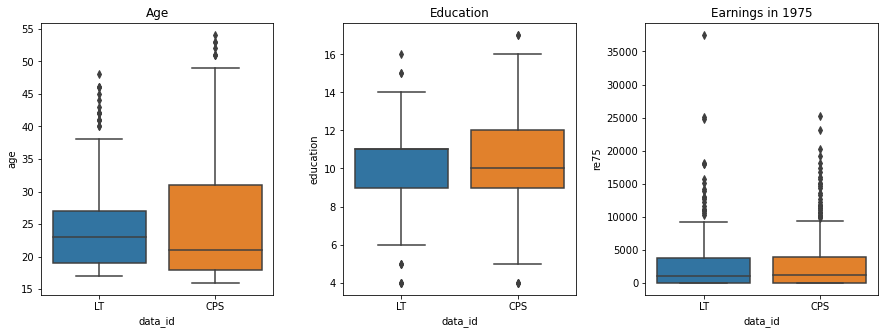

In [31]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

PSID

In [32]:
df_LT_PSID = fn_generate_data(treat_id = 'LT', control_id = 'PSID', df = df)
X, D = fn_generate_variables(outcome = None, df = df_LT_PSID)
phat_logit_LT_PSID = fn_propensity_score(X, D, method = 'logit')

df_matched = fn_generate_df_matched(df = df_LT_PSID, prop = phat_logit_LT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,LT,PSID
treat,1.000000,0.000000
age,24.513605,24.312925
education,10.394558,10.435374
black,0.802721,0.826531
hispanic,0.095238,0.105442
married,0.163265,0.156463
nodegree,0.727891,0.690476
re75,2859.766375,3233.145989
re78,5958.267558,7001.418233
dif,3098.501184,3768.272243


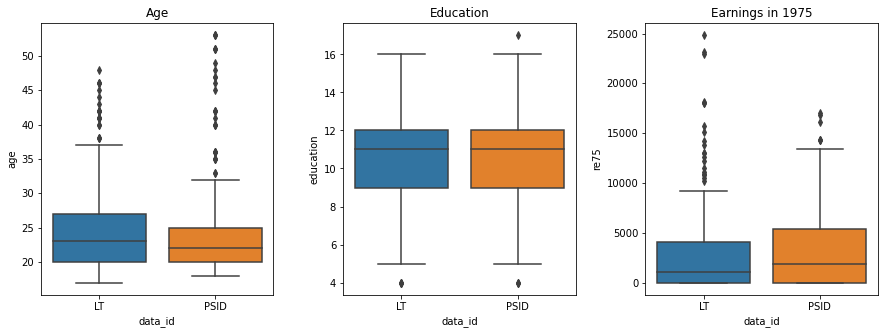

In [33]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

How about DW dataset?

In [34]:
df_DWT_CPS = fn_generate_data(treat_id = 'DWT', control_id = 'CPS', df = df)
X, D = fn_generate_variables(outcome = None, df = df_DWT_CPS)
phat_logit_DWT_CPS = fn_propensity_score(X, D, method = 'logit')

df_matched = fn_generate_df_matched(df = df_DWT_CPS, prop = phat_logit_DWT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,CPS,DWT
treat,0.000000,1.000000
age,24.493976,25.620482
education,10.500000,10.216867
black,0.927711,0.915663
hispanic,0.036145,0.048193
married,0.156627,0.156627
nodegree,0.680723,0.746988
re75,945.376631,1053.871833
re78,5246.258639,6004.840528
re74,1668.480926,1676.139672


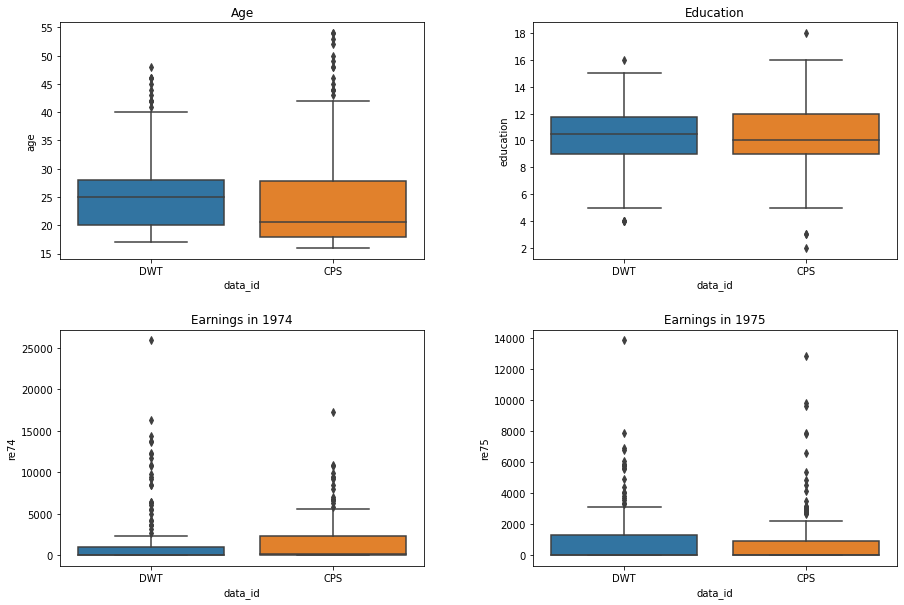

In [35]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [36]:
df_DWT_PSID = fn_generate_data(treat_id = 'DWT', control_id = 'PSID', df = df)
X, D = fn_generate_variables(outcome = None, df = df_DWT_PSID)
phat_logit_DWT_PSID = fn_propensity_score(X, D, method = 'logit')

df_matched = fn_generate_df_matched(df = df_DWT_PSID, prop = phat_logit_DWT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,DWT,PSID
treat,1.000000,0.000000
age,25.638889,25.033333
education,10.333333,10.455556
black,0.838889,0.888889
hispanic,0.061111,0.038889
married,0.166667,0.127778
nodegree,0.711111,0.727778
re75,1133.351571,1735.041407
re78,6117.885886,5943.539499
re74,1613.143910,3981.415164


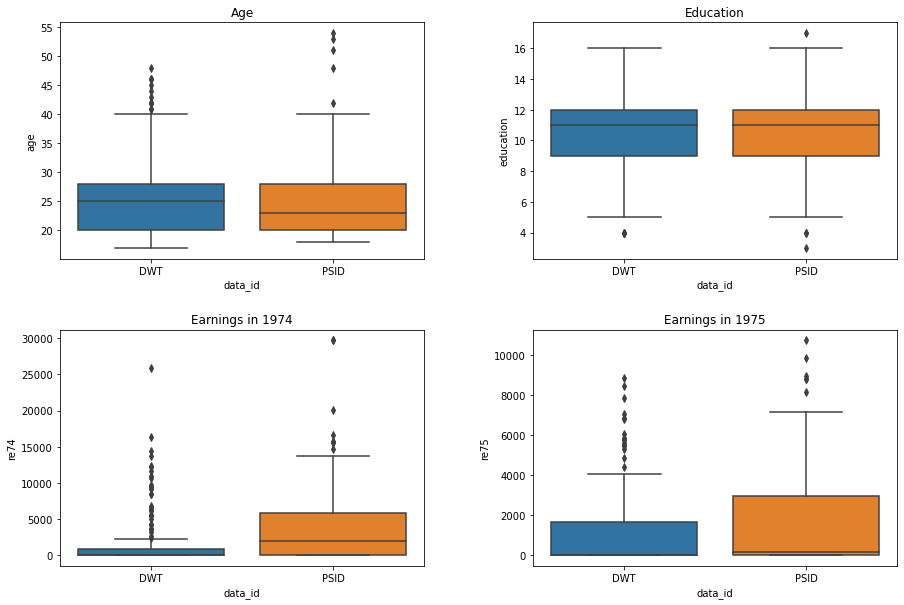

In [37]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

Better than LaLonde?

#### 3.2.2 Estimate propensity score by Random Forest

LaLonde dataset

In [38]:
X, D = fn_generate_variables(outcome = None, df = df_LT_CPS)

param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

phat_RF_LT_CPS = fn_propensity_score(X, D, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_LT_CPS, prop = phat_RF_LT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched.head(10)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,dif,propensity_score,propensity_score_logit,matched_index_1,matched_outcome_1,distance_1,matched_outcome_average
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,9930.045898,0.659518,0.661146,741.0,0.000000,0.011800,0.000000
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,3595.894043,0.731000,0.999702,741.0,0.000000,0.326756,0.000000
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,24909.449219,0.322532,-0.742159,1108.0,1161.493042,0.000000,1161.493042
3,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,289.789886,0.793000,1.343104,741.0,0.000000,0.670158,0.000000
4,LT,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,4056.493896,4056.493896,0.884267,2.033470,741.0,0.000000,1.360524,0.000000
5,LT,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.337006,-0.676665,566.0,7062.055176,0.000000,7062.055176
6,LT,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,8472.158203,8472.158203,0.856355,1.785338,741.0,0.000000,1.112392,0.000000
7,LT,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,2164.021973,2164.021973,0.436370,-0.255907,583.0,116.740402,0.000000,116.740402
8,LT,1.0,33.0,12.0,0.0,0.0,1.0,0.0,0.0,12418.070312,12418.070312,0.064601,-2.672738,862.0,9297.856445,0.000000,9297.856445
9,LT,1.0,19.0,9.0,1.0,0.0,0.0,1.0,0.0,8173.908203,8173.908203,0.532539,0.130341,851.0,0.000000,0.000000,0.000000


In [39]:
# Conditional mean
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,CPS,LT
treat,0.000000,1.000000
age,17.682594,24.597270
education,10.116041,10.372014
black,0.979522,0.798635
hispanic,0.000000,0.095563
married,0.013652,0.170648
nodegree,0.955631,0.726962
re75,0.000000,3107.956187
re78,464.066686,5971.638722
dif,464.066686,2863.682536


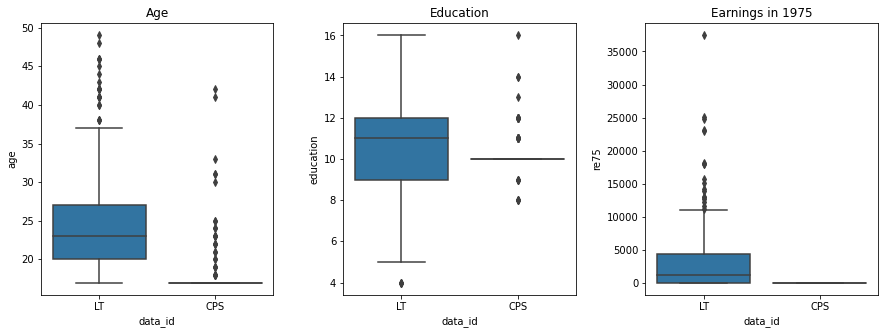

In [40]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

In [41]:
X, D = fn_generate_variables(outcome = None, df = df_LT_PSID)

phat_RF_LT_PSID = fn_propensity_score(X, D, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_LT_PSID, prop = phat_RF_LT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,LT,PSID
treat,1.000000,0.000000
age,25.660944,24.480687
education,10.472103,11.866953
black,0.785408,0.965665
hispanic,0.090129,0.000000
married,0.214592,0.025751
nodegree,0.695279,0.141631
re75,3715.850720,23.051364
re78,6033.287331,2000.397843
dif,2317.436611,1977.346480


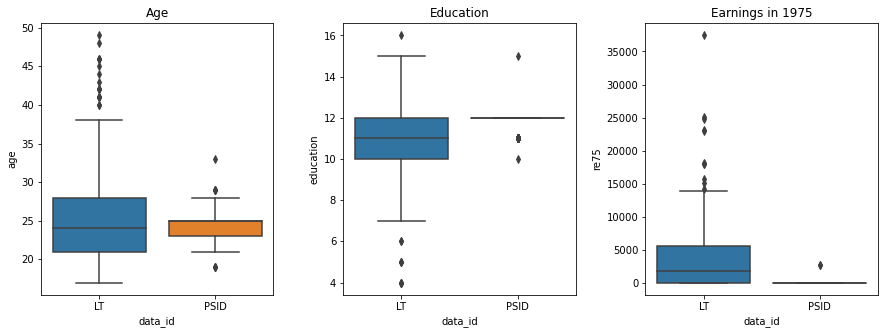

In [42]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

Surprisingly, Random Forest fails to make treatment and control groups comparable.

DW dataset

In [43]:
X, D = fn_generate_variables(outcome = None, df = df_DWT_CPS)

phat_RF_DWT_CPS = fn_propensity_score(X, D, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_DWT_CPS, prop = phat_RF_DWT_CPS, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,CPS,DWT
treat,0.000000,1.000000
age,18.150838,25.804469
education,10.128492,10.391061
black,0.966480,0.837989
hispanic,0.000000,0.061453
married,0.022346,0.195531
nodegree,0.921788,0.698324
re75,0.000000,1583.409122
re78,1238.227558,6318.077388
re74,260.418323,2165.816387


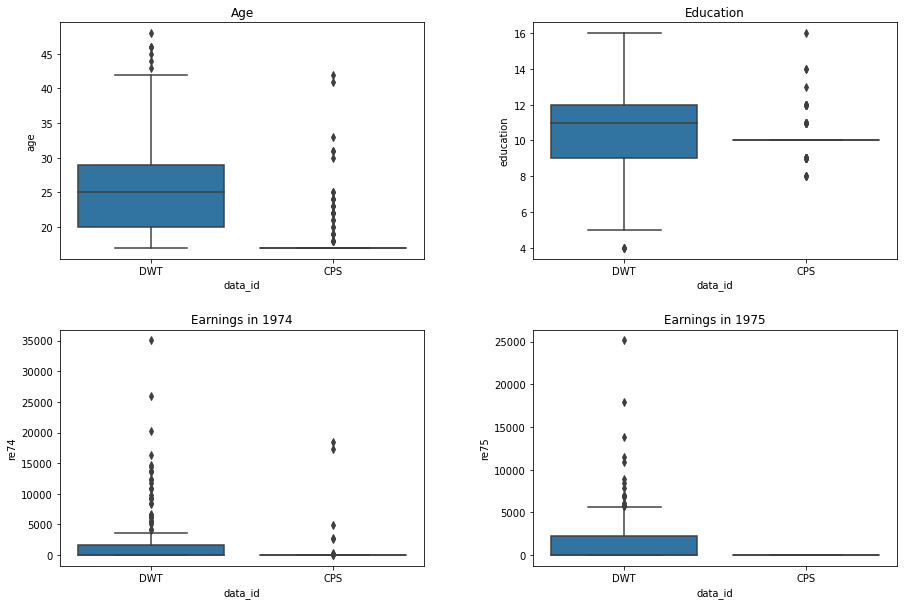

In [44]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [45]:
X, D = fn_generate_variables(outcome = None, df = df_DWT_PSID)

phat_RF_DWT_PSID = fn_propensity_score(X, D, method = 'RF', param_grid = param_grid)

df_matched = fn_generate_df_matched(df = df_DWT_PSID, prop = phat_RF_DWT_PSID, outcome = 'dif',
                                    n_neighbors = 1, caliper = np.inf)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,DWT,PSID
treat,1.000000,0.000000
age,26.370130,24.792208
education,10.454545,11.162338
black,0.811688,0.974026
hispanic,0.071429,0.000000
married,0.220779,0.090909
nodegree,0.688312,0.805195
re75,1800.033351,0.000000
re78,6459.159244,4065.331338
re74,2464.745515,659.026083


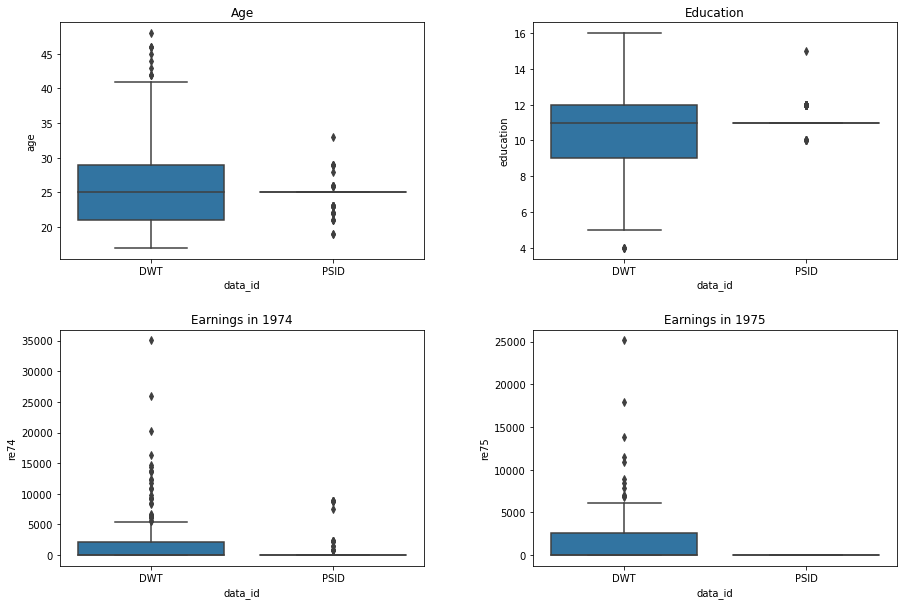

In [46]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

Basically the same with LaLonde dataset.

#### 3.2.3 ATE and ATET estimates

In [47]:
param_grid_p = {'n_estimators': [50, 100, 500, 1000],
                'max_features': [2, 3, 4, 5]}
param_grid_mu = {'n_estimators': [50, 100, 500, 1000],
                 'max_features': [2, 3, 4, 5]}

df_results = fn_generate_df_results(df = df, param_grid_p = param_grid_p, param_grid_mu = param_grid_mu)

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [2:33:24<00:00, 4602.19s/it]


In [48]:
# Output the results as .csv file
df_results.to_csv('./results/others.csv', index = False)

In [49]:
PSM_summary = fn_pick_results(df_results, method = 'PSM')
PSM_summary[PSM_summary.Outcome == 'dif'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,PSM,logit,-2122.159242,-142.154448
1,dif,LT,CPS,PSM,RF,6954.276115,2482.696058
2,dif,LT,CPS,PSM,GB,-1269.748110,-1507.176730
3,dif,LT,PSID,PSM,logit,-3094.999675,-669.771060
4,dif,LT,PSID,PSM,RF,5368.636902,788.037132
5,dif,LT,PSID,PSM,GB,-1779.832846,-1380.062615
6,dif,DWT,CPS,PSM,logit,1294.610131,650.086686
7,dif,DWT,CPS,PSM,RF,7119.566201,4367.907995
8,dif,DWT,CPS,PSM,GB,1988.773688,1621.932216
9,dif,DWT,PSID,PSM,logit,-461.855669,776.036224


In [50]:
PSM_summary[PSM_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,re78,LT,CPS,PSM,logit,-889.828448,-366.189363
1,re78,LT,CPS,PSM,RF,3722.119805,5592.789588
2,re78,LT,CPS,PSM,GB,-1098.218475,-588.125017
3,re78,LT,PSID,PSM,logit,-1589.727296,-1043.150675
4,re78,LT,PSID,PSM,RF,1493.707987,4277.729378
5,re78,LT,PSID,PSM,GB,-3509.861818,-662.849576
6,re78,DWT,CPS,PSM,logit,1199.540079,758.581889
7,re78,DWT,CPS,PSM,RF,4876.358489,5969.208745
8,re78,DWT,CPS,PSM,GB,1317.323116,2135.445330
9,re78,DWT,PSID,PSM,logit,-129.761621,174.346387


### 3.3 Inverse Probability of Treatment Weighted (IPTW) Estimator

#### 3.3.1 Estimate propensity score by logistic regression

In [51]:
IPTW_summary = fn_pick_results(df_results, method = 'IPTW')
IPTW_summary[IPTW_summary.Est_Prop == 'logit'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,IPTW,logit,-2779.761998,6757.324781
1,dif,LT,PSID,IPTW,logit,-5954.985771,-7931.309665
2,dif,DWT,CPS,IPTW,logit,-192.714901,37965.656909
3,dif,DWT,PSID,IPTW,logit,-1076.628815,13108.990548
4,re78,LT,CPS,IPTW,logit,-1634.390493,65067.335237
5,re78,LT,PSID,IPTW,logit,-2196.506472,29744.600824
6,re78,DWT,CPS,IPTW,logit,-1008.058240,54524.953302
7,re78,DWT,PSID,IPTW,logit,-2806.561656,20278.006198


#### 3.3.2 Estimate propensity score by Random Forest

In [52]:
IPTW_summary[IPTW_summary.Est_Prop == 'RF'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,IPTW,RF,-1035.757318,5129.302893
1,dif,LT,PSID,IPTW,RF,-1915.618797,2637.611559
2,dif,DWT,CPS,IPTW,RF,-1101.491182,9133.441985
3,dif,DWT,PSID,IPTW,RF,-1436.295796,5760.130864
4,re78,LT,CPS,IPTW,RF,-4142.798296,9551.710494
5,re78,LT,PSID,IPTW,RF,-5695.350332,7345.858045
6,re78,DWT,CPS,IPTW,RF,-3317.300434,11416.384136
7,re78,DWT,PSID,IPTW,RF,-5960.908301,8263.475550


#### 3.3.3 Estimate propensity score by Gradient Boosting

In [53]:
IPTW_summary[IPTW_summary.Est_Prop == 'GB'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,IPTW,GB,-2319.833092,7736.430865
1,dif,LT,PSID,IPTW,GB,-3767.388029,-1748.623748
2,dif,DWT,CPS,IPTW,GB,-1216.284100,18379.270554
3,dif,DWT,PSID,IPTW,GB,-238.041574,15810.804869
4,re78,LT,CPS,IPTW,GB,-1074.836246,53976.863176
5,re78,LT,PSID,IPTW,GB,-7912.901504,23848.366620
6,re78,DWT,CPS,IPTW,GB,-438.211696,51901.746303
7,re78,DWT,PSID,IPTW,GB,1299.098019,46352.529084


### 3.4 Doubly Robust Estimator

#### 3.4.1 Estimate $\mu_1(X)$ and $\mu_0(X)$ by Random Forest

In [54]:
DR_summary = fn_pick_results(df_results, method = 'DR')
DR_summary[(DR_summary.Outcome == 'dif') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE,ATET
0,dif,LT,CPS,DR,logit,RF,-1076.683441,-2936.836615
1,dif,LT,CPS,DR,RF,RF,-255.807581,-206.559653
2,dif,LT,CPS,DR,GB,RF,-588.887524,-136.944284
3,dif,LT,PSID,DR,logit,RF,-3135.306290,-5498.594844
4,dif,LT,PSID,DR,RF,RF,-2245.285259,-1984.028433
5,dif,LT,PSID,DR,GB,RF,-2906.402161,-3596.093656
6,dif,DWT,CPS,DR,logit,RF,827.326364,-1018.422329
7,dif,DWT,CPS,DR,RF,RF,1315.768043,1448.507137
8,dif,DWT,CPS,DR,GB,RF,100.200163,-6365.796077
9,dif,DWT,PSID,DR,logit,RF,-315.063232,-937.845959


In [55]:
DR_summary[(DR_summary.Outcome == 're78') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE,ATET
0,re78,LT,CPS,DR,logit,RF,-791.013428,-2257.066761
1,re78,LT,CPS,DR,RF,RF,-267.845231,-301.031054
2,re78,LT,CPS,DR,GB,RF,-745.703861,-2313.917097
3,re78,LT,PSID,DR,logit,RF,-2816.792834,-2968.427718
4,re78,LT,PSID,DR,RF,RF,-3357.591736,-2357.368105
5,re78,LT,PSID,DR,GB,RF,-4044.339813,-2139.347045
6,re78,DWT,CPS,DR,logit,RF,870.608148,-807.871955
7,re78,DWT,CPS,DR,RF,RF,1287.539204,1396.586434
8,re78,DWT,CPS,DR,GB,RF,184.760123,-6363.123249
9,re78,DWT,PSID,DR,logit,RF,-666.669290,-1325.769258


#### 3.4.2 Estimate $\mu_1(X)$ and $\mu_0(X)$ by Gradient Boosting

In [56]:
DR_summary[(DR_summary.Outcome == 'dif') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE,ATET
0,dif,LT,CPS,DR,logit,GB,-983.256716,1216.736243
1,dif,LT,CPS,DR,RF,GB,-629.696234,-73.815465
2,dif,LT,CPS,DR,GB,GB,-1097.459249,-1304.715280
3,dif,LT,PSID,DR,logit,GB,-4988.690569,-15786.843833
4,dif,LT,PSID,DR,RF,GB,-2352.703521,-2031.577715
5,dif,LT,PSID,DR,GB,GB,-4019.313530,-7539.894718
6,dif,DWT,CPS,DR,logit,GB,667.640594,820.266550
7,dif,DWT,CPS,DR,RF,GB,977.726316,1955.613929
8,dif,DWT,CPS,DR,GB,GB,-530.172744,-5720.612134
9,dif,DWT,PSID,DR,logit,GB,-415.959083,-1471.830995


In [57]:
DR_summary[(DR_summary.Outcome == 're78') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE,ATET
0,re78,LT,CPS,DR,logit,GB,-1416.633215,-2713.576338
1,re78,LT,CPS,DR,RF,GB,-501.426052,-71.752330
2,re78,LT,CPS,DR,GB,GB,-1237.715357,-2316.750019
3,re78,LT,PSID,DR,logit,GB,-4433.308384,-11740.394981
4,re78,LT,PSID,DR,RF,GB,-3188.058286,-2979.217017
5,re78,LT,PSID,DR,GB,GB,-4221.955379,-6509.578308
6,re78,DWT,CPS,DR,logit,GB,375.558485,-540.206337
7,re78,DWT,CPS,DR,RF,GB,734.145998,1853.971375
8,re78,DWT,CPS,DR,GB,GB,-474.566720,-7390.898803
9,re78,DWT,PSID,DR,logit,GB,-314.340214,-3585.849439


## 4. Findings

a. What are your main findings?  
b. Are your findings robust to different model specifications?

The first table shows the results of treatment effect estimated by linear regression model. The experimental treatment effects ranges from 798 to 886 for Lalonde data, and ranges from 1375 to 1794 for Dehejia and Wahba data, considering different specifications and outcome variable. 

Overall, the regression results of the non-experiment data fail to generate similar results of experiment results neither for Lalonde's data nor for DW's data, where the closest one differs more than 400 from the true. In addition, the non-experiment treatment effects are very sensitive to the outcome variable, they are mostly positive when outcome variable is 're78 - re75' but mostly negative when it is 're78'. In addition, they are also sensitive to the covariates that we control. The ranges are more than 1000 when outcome variable is 're78 - re75' and are more than 4000 when it is 're78'.


In [58]:
reg_summary_dif

,Outcome,Treatment,Control,Without control,With age,With all control
0,dif,LT,LC,846.888287,856.910955,802.048565
1,dif,LT,CPS,1714.397705,195.174602,-1102.322439
2,dif,LT,PSID,419.670577,-749.207210,-2118.596666
3,dif,DWT,DWC,1529.196083,1516.996931,1631.410849
4,dif,DWT,CPS,3621.232061,2383.311533,524.908817
5,dif,DWT,PSID,2326.504934,1256.927930,-265.312462


In [59]:
reg_summary_re78

,Outcome,Treatment,Control,Without control,With age,With all control
0,re78,LT,LC,886.303722,881.739626,802.048565
1,re78,LT,CPS,-8870.307627,-7172.308044,-1102.322439
2,re78,LT,PSID,-15577.568900,-13267.657059,-2118.596666
3,re78,DWT,DWC,1794.342382,1736.057724,1631.410849
4,re78,DWT,CPS,-8497.516148,-7274.306837,524.908817
5,re78,DWT,PSID,-15204.777421,-13268.950367,-265.312462


The second and third table shows the results of treatment effect estimated by Random Forest Regression and Gradient Boosting Regression. The main finding is that PSID control group could generate similar treatment effect as the experiment data does for the Lalonde data when the outcome variable is 're78 - re75'. Their difference is only about 70 under both method, while the difference is more than 700 for the DW's data. It somehow provides the support for the conjecture that the linear specification may be wrong when estimating the non-experiment treatment effect.

In [60]:
RF_summary

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,RF,925.719366,828.639413
1,dif,LT,CPS,Regression,RF,-3904.957588,-79.880557
2,dif,LT,PSID,Regression,RF,-2534.592592,-1103.409363
3,dif,DWT,DWC,Regression,RF,1321.584018,1371.181891
4,dif,DWT,CPS,Regression,RF,-961.479719,1305.923066
5,dif,DWT,PSID,Regression,RF,165.951550,-142.114025
6,re78,LT,LC,Regression,RF,843.142086,772.155457
7,re78,LT,CPS,Regression,RF,-2627.440297,-162.500008
8,re78,LT,PSID,Regression,RF,-6055.492406,-1439.062225
9,re78,DWT,DWC,Regression,RF,1413.912273,1578.855844


In [61]:
GB_summary

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,GB,660.608000,696.555550
1,dif,LT,CPS,Regression,GB,-4763.527776,-610.415858
2,dif,LT,PSID,Regression,GB,-2324.187412,-721.001035
3,dif,DWT,DWC,Regression,GB,1294.474855,1303.139926
4,dif,DWT,CPS,Regression,GB,-2381.882741,993.774611
5,dif,DWT,PSID,Regression,GB,-657.435550,675.610266
6,re78,LT,LC,Regression,GB,694.708959,712.838403
7,re78,LT,CPS,Regression,GB,-3820.272868,-684.446271
8,re78,LT,PSID,Regression,GB,-5273.560652,-1579.772112
9,re78,DWT,DWC,Regression,GB,1388.528556,1482.908466


The fourth table shows the results of treatment effect estimated by Propensity Score Matching, where it uses logit regression or random forest to estimate the propensity score. For the Lalonde data, the treatment effect remains negative if it uses logit regression to estimate the propensity score. The main finding here is that CPS control group, given the outcome variable 're78 - re75' and random forest method to estimate the propensity score, could generate 794 average treatment effect on the treated, which is very close to the true treatment effect 819 estimated by linear regression and 793 estimated by Gradient Boosting.

On the other hand, for the DW data, the treatment effects are all positive, but are at least 1000 larger than the true effect if it uses random forest to estimate the propensity score. The main finding in DW data here is that if it uses logit regression to estimate the propensity score, CPS control group could generate 1324 average treatment effect when the outcome variable is 're78 - re75' and 1229 average treatment effect when the outcome variable is 're78', they are very close to true treatment effect 1375 estimated by linear regression, 1335 estimated by Random Forest and 1124 estimated by Gradient Boosting.

Overall, when it uses propensity score matching to estimate the non-experimental treatment effect, CPS group could provide similar results as the experimental treatment effect under the condition that estimation method and outcome variable are correctly specified.

In [62]:
PSM_summary

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,PSM,logit,-2122.159242,-142.154448
1,dif,LT,CPS,PSM,RF,6954.276115,2482.696058
2,dif,LT,CPS,PSM,GB,-1269.748110,-1507.176730
3,dif,LT,PSID,PSM,logit,-3094.999675,-669.771060
4,dif,LT,PSID,PSM,RF,5368.636902,788.037132
5,dif,LT,PSID,PSM,GB,-1779.832846,-1380.062615
6,dif,DWT,CPS,PSM,logit,1294.610131,650.086686
7,dif,DWT,CPS,PSM,RF,7119.566201,4367.907995
8,dif,DWT,CPS,PSM,GB,1988.773688,1621.932216
9,dif,DWT,PSID,PSM,logit,-461.855669,776.036224


The fifth table shows the results of treatment effect estimated by Inverse Probability of Treatment Weighted. All of the average treatment effect estimated by this method remain negative. Therefore, it concludes that this method is not an appropriate one to estimate the non-experiment treatment effect.

In [63]:
IPTW_summary

,Outcome,Treatment,Control,Method,Est_Prop,ATE,ATET
0,dif,LT,CPS,IPTW,logit,-2779.761998,6757.324781
1,dif,LT,CPS,IPTW,RF,-1035.757318,5129.302893
2,dif,LT,CPS,IPTW,GB,-2319.833092,7736.430865
3,dif,LT,PSID,IPTW,logit,-5954.985771,-7931.309665
4,dif,LT,PSID,IPTW,RF,-1915.618797,2637.611559
5,dif,LT,PSID,IPTW,GB,-3767.388029,-1748.623748
6,dif,DWT,CPS,IPTW,logit,-192.714901,37965.656909
7,dif,DWT,CPS,IPTW,RF,-1101.491182,9133.441985
8,dif,DWT,CPS,IPTW,GB,-1216.284100,18379.270554
9,dif,DWT,PSID,IPTW,logit,-1076.628815,13108.990548


The last table shows the results of treatment effect estimated by Doubly Robust Estimation. It still remain negative for all the average treatment effect in the Lalonde data and for the average treatment effect using PSID control group in the DW data. The main finding here is that CPS control group in the DW data could generate similar result as the true treatment effect, especially when it uses random forest to estimate $\mu$. It generates 1233 when 're78 - re75' works as the outcome variable and 1253 when 're78' does, and they are very close to true treatment effect 1375 estimated by linear regression, 1335 estimated by Random Forest and 1124 estimated by Gradient Boosting.

In [64]:
DR_summary

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE,ATET
0,dif,LT,CPS,DR,logit,RF,-1076.683441,-2936.836615
1,dif,LT,CPS,DR,logit,GB,-983.256716,1216.736243
2,dif,LT,CPS,DR,RF,RF,-255.807581,-206.559653
3,dif,LT,CPS,DR,RF,GB,-629.696234,-73.815465
4,dif,LT,CPS,DR,GB,RF,-588.887524,-136.944284
5,dif,LT,CPS,DR,GB,GB,-1097.459249,-1304.715280
6,dif,LT,PSID,DR,logit,RF,-3135.306290,-5498.594844
7,dif,LT,PSID,DR,logit,GB,-4988.690569,-15786.843833
8,dif,LT,PSID,DR,RF,RF,-2245.285259,-1984.028433
9,dif,LT,PSID,DR,RF,GB,-2352.703521,-2031.577715


In conclusion, this paper conducts several estimation methods to investigate the non-experiment treatment effect with the CPS and PSID data. Although it finds that under some conditions that the non-experiment data could generate similar results as the experiment data does, the results are very sensitive to the outcome variable, the estimation method and the control group. Therefore, it should be cautious to reach the conclusion that we can estimate casual effects in NSW using non-experiment data.

In the Propensity Score Matching estimation, it could generate similar results for Lalonde data and DW data that CPS control group could replicate the true treatment, with only the exception that they need to use different method to estimate the propensity score. However, the results differ between Lalonde and DW data in other estimation strategies.
PSID could replicate the results for Lalonde data in the Random Forest Regression and Gradient Boosting Regression, while CPS does for DW data in the Doubly Robust Estimation. 

Overall, this results could somehow provide support for Dehejia and Wahba (1999, 2002) that propensity score matching estimation could alleviate the bias due to systematic differences between the treated and comparison units and replicate the causal effect in NSW with non-experiment dataset.

## 5. Conclusion

a. Discuss what we’ve learned from your analysis.  
b. Discuss any questions that could be answered in the future.

We re-examined whether the causal effect can be estimated of the NSW with nonexperimental data, which is a long-standing debate, by incorporating various machine learning methods, such as Random Forest Regression and Gradient Boosting Regression, into the causal inference and trying various specifications. Our analysis provides new arguments to support the conclusion of DW, while reconcile the possibility that Lalonde and DW have different conclusions due to different datasets.

From the analysis, we mainly leads to two conclusions. First, our study estimating causal effects in NSW using nonexperimental data is not generalizable, and it depends on the outcome variable, estimation method, and control group. Second, the results for Lalonde and DW are different under the same model, and using different methods for estimation may yield similar results.

In future research, firstly, we can try to find a way to enhance the robustness of the results so that the model can be widely applicable to the estimation of the casual effect in a specific context. Furthermore, we can focus on how to choose an appropriate model without experimental data, because in economics research, there is no random experiment in most situations, so how to identify the best specification in this case is the key to the problem.

## Endnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Aid to Families with Dependent Children.

## References

1. Abadie, A., & Cattaneo, M. D. (2008). Econometric methods for program evaluation. *Annual Review of Economics*, 10(1), 465&ndash;503.
2. Dehejia, R., & Wahba, S. (1999). Causal effects in nonexperimental studies: Reevaluating the evaluation of training programs. *Journal of the American Statistical Association*, 94(448), 1053&ndash;1062.  
3. Dehejia, R., & Wahba, S. (2002). Propensity score-matching methods for nonexperimental causal studies. *Review of Economics and Statistics*, 84(1), 151&ndash;161.  
4. LaLonde, R. (1986). Evaluating the econometric evaluations of training programs with experimental data. *American Economic Review*, 76(4), 604&ndash;620.  
5. Müller, A. C., & Guido, S. (2016). *Introduction to machine learning with Python: A guide for data scientists.* O'Reilly Media.
6. Smith, J. A., & Todd, P. E. (2005). Does matching overcome LaLonde’s critique of nonexperimental estimators? *Journal of Econometrics*, 125(1–2), 305&ndash;353.  